In [1]:
import os, json

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

## Tracing Setup

In [ ]:
# [START trace_function]
from opentelemetry.trace import get_tracer

from tracing import init_tracing, tracer, root_span

# tracer = init_tracing(False) # this was done in tracing.py already
tracer

## Define tools for the agent

We will define a few tools that the agent will use to interact with the database.

1. `list_tables_tool`: Fetch the available tables from the database
2. `get_schema_tool`: Fetch the DDL for a table
3. `db_query_tool`: Execute the query and fetch the results OR return an error message if the query fails

For the first two tools, we will grab them from the `SQLDatabaseToolkit`, also available in the `langchain_community` package.

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///chinook.db")
print(db.dialect)
print(db.get_usable_table_names())


sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [6]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_version=os.environ["AZURE_OPENAI_API_VERSION"],   # tool_choice="required" is only supported in 2024-06-01 and later
    azure_deployment="gpt-4o",
    streaming=True,
    temperature=0
)

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

for tool in tools:
    print(tool.name)
    print(f"\t{tool.description}\n")

sql_db_query
	Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema
	Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables
	Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker
	Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [7]:
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

In [8]:
from typing import Any

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [9]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field

class GenerateQuery(BaseModel):
    """Generate a query based on the question and schema."""
    query: str = Field(..., description="The generated query to run on the sqlite3 database.")


@tool(args_schema=GenerateQuery)
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    if result.startswith("Error:"):
        return result + "\nPlease rewrite your query and try again."
    return result   # above if condition is not required as "run_no_throw returns error too"


sql_query = db_query_tool.invoke('SELECT * FROM Artist LIMIT 10;')
print(sql_query)

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


# Define a Graph
## Visualize and Run the workflow

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [10]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

# # Transient in-memory database. This database exists only in RAM and will be lost once the connection is closed or the program terminates. 
# conn = sqlite3.connect(":memory:", check_same_thread = False)
# checkpointer = SqliteSaver(conn)

# Save to local db instead of :memory: to persist state 
db_path = "checkpointer_db/state.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
checkpointer = SqliteSaver(conn)

In [11]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import AzureChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages, MessagesState

# MessagesState takes care of this, so we do not need to define this
# 
# class State(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

In [12]:
# Add a node for the first tool call
def list_tables_ai_call(state: MessagesState) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

In [13]:
def get_db_schema(state: MessagesState):  
    get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
    model_get_schema  = llm.bind_tools([get_schema_tool])
    
    messages = state["messages"]
    db_schema = model_get_schema.invoke(messages)
    return {"messages": [db_schema]}

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
# from pydantic import BaseModel, Field

QUERY_GEN_SYSTEM_MSG = """You are a SQL expert with a strong attention to detail.

You have access to a SQLite database through a db_query_tool that can execute queries on the database.
Given an input question, call the tool by generating a syntactically correct SQLite query without wrapping it in any sql or markers by using "GenerateQuery" tool schema definition.
If the query fails, you will be prompted to rewrite the query and try again. 
If the query is correct, you will get the result of the query, which you can then use to answer the question.

When extracting the query argument for the tool, follow the following INSTRUCTIONS:

- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 50 results.
- ALWAYS ORDER the results by a relevant column to return the most interesting examples in the database, preferrably in descending order of numeric values using DESC.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, you will be prompted to rewrite the query and try again.
- NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information or ask for clarification.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""   
    



def query_agent_node(state: MessagesState) -> MessagesState:
    try:
        with tracer.start_as_current_span("query_agent_node") as span:  
            messages = state["messages"]
            questions = [msg for msg in messages if msg.type == 'human' and msg.name is None]
            latest_question = questions[-1].content if questions else None
            span.set_attribute("input.question", latest_question)

            query_gen_prompt = ChatPromptTemplate.from_messages(
                [("system", QUERY_GEN_SYSTEM_MSG), ("human", "{messages}")]
            )
            query_gen = query_gen_prompt | llm.bind_tools([db_query_tool])
            query_response = query_gen.invoke({'messages': messages})
            
            if len(query_response.tool_calls) > 0:
                for i, tc in enumerate(query_response.tool_calls):
                    span.set_attribute(f"output.query{i+1}", str(tc['args']['query']))
            else:
                span.set_attribute("output.answer", str(query_response.content))
            
            return {"messages": [query_response]}
        
    except Exception as e:
            # logging.error(f"Error in query_agent_node: {e}")
            print(f"Error in query_agent_node: {e}")
            return {"messages": [AIMessage(content="An error occurred: {e}. Please retry.")]}

In [15]:
def db_tool_node(state: MessagesState):
    with tracer.start_as_current_span("db_tool_node") as span: 
        tool_calls = state["messages"][-1].tool_calls        
        tools_mapping = {"db_query_tool": db_query_tool}
        
        results = []        
        for tool_call in tool_calls:
            print(f"Calling: {tool_call}")
            if not tool_call['name'] in tools_mapping.keys():     # check for bad tool name from LLM
                print("\n ....bad tool name....")
                span.set_attribute("input.tool_name", str(tool_call["name"]))
                output = "bad tool name, retry"  # instruct LLM to retry
                span.set_attribute("output.error", str(output))
            else:
                tool = tools_mapping[tool_call["name"].lower()]
                span.set_attribute("input.tool_name", str(tool_call["name"]))
                span.set_attribute("input.query", str(tool_call["args"]["query"]))
                output = tool.invoke(tool_call["args"])        
                span.set_attribute("output.db_result", str(output))   
            
            results.append(ToolMessage(
                        tool_call_id=tool_call['id'], 
                        name=tool_call['name'], 
                        content=str(output)
                    ))
        # print(f"Tool Results: {results}")
        state['messages'] = results
        return state

In [16]:
# def tool_check(state: MessagesState) -> Literal["query_db", "__end__"]:
#     messages = state["messages"]
#     last_message = messages[-1]
    
#     if len(last_message.tool_calls) > 0:
#         return "query_db"
#     else:
#         return "__end__"

def tool_check(state: MessagesState) -> Literal["query_db", "generate_answer"]:
    messages = state["messages"]
    last_message = messages[-1]
    
    if len(last_message.tool_calls) > 0:
        return "query_db"
    else:
        return "generate_answer"
    

In [17]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import RemoveMessage, add_messages

def delete_intermediate_messages(state: MessagesState):
    return {"messages": [RemoveMessage(id=msg.id) for msg in state['messages']  if (msg.type == "tool" or msg.content=="")]}   
    # return {"messages": [RemoveMessage(id=msg.id) for msg in state['messages']  if (msg.type == "tool" or (msg.type =="ai" and msg.tool_calls))]}

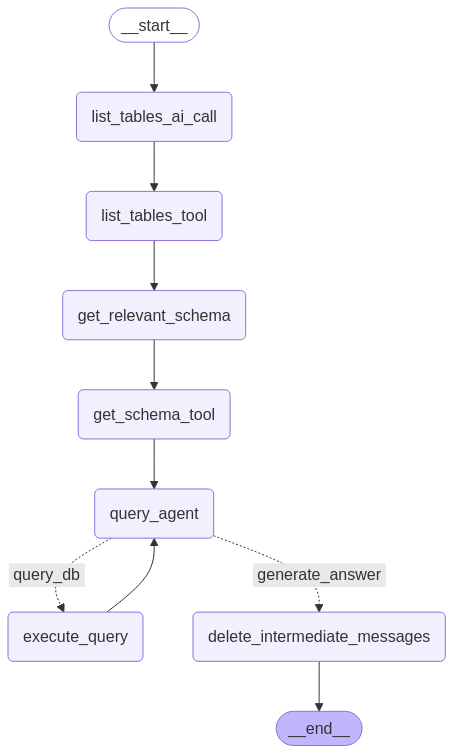

In [18]:
# Define a new graph
workflow = StateGraph(MessagesState)



workflow.add_node("list_tables_ai_call", list_tables_ai_call)
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)

workflow.add_node("get_relevant_schema", get_db_schema)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

workflow.add_node("query_agent", query_agent_node)
workflow.add_node("execute_query", db_tool_node)
workflow.add_node("delete_intermediate_messages", delete_intermediate_messages)



workflow.add_edge(START, "list_tables_ai_call")
workflow.add_edge("list_tables_ai_call", "list_tables_tool") 
workflow.add_edge("list_tables_tool", "get_relevant_schema")
workflow.add_edge("get_relevant_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_agent")
workflow.add_conditional_edges(
    "query_agent",
    tool_check,
    # {"query_db": "execute_query", "__end__": END}
    {"query_db": "execute_query", "generate_answer": "delete_intermediate_messages"},
)
workflow.add_edge("execute_query", "query_agent")
workflow.add_edge("delete_intermediate_messages", END)  


# Compile the workflow into a runnable
sql_graph = workflow.compile(checkpointer=checkpointer)

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        sql_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Conversation Test 1

In [19]:
import uuid

session_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": session_id}}
print(f"Session ID: {session_id}\n")

from langchain_core.messages import HumanMessage
user_input = "Hi, can you tell me the names of popular albums in the database?"

with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
result['messages']

Session ID: cbcc4447-e433-4e25-9bcb-cab585016f9c

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Title FROM Album ORDER BY AlbumId DESC LIMIT 50'}, 'id': 'call_eIm7qMCkaQFzgnTBF9RAoVdX', 'type': 'tool_call'}


[HumanMessage(content='Hi, can you tell me the names of popular albums in the database?', additional_kwargs={}, response_metadata={}, id='d5031384-8ea4-415c-94c7-815517dcbd9f'),
 AIMessage(content="Here are some popular album titles from the database:\n\n1. Koyaanisqatsi (Soundtrack from the Motion Picture)\n2. Mozart: Chamber Music\n3. Monteverdi: L'Orfeo\n4. Schubert: The Late String Quartets & String Quintet (3 CDs)\n5. Respighi: Pines of Rome\n6. Locatelli: Concertos for Violin, Strings and Continuo, Vol. 3\n7. Great Recordings of the Century - Shubert: Schwanengesang, 4 Lieder\n8. Liszt - 12 Études D'Execution Transcendante\n9. Great Recordings of the Century: Paganini's 24 Caprices\n10. Nielsen: The Six Symphonies\n\nIf you need more information or additional titles, feel free to ask!", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-9184088e-fac4-4d1a-85f6-a3d81e952339-0')]

In [20]:
from IPython.display import Markdown, display
display(Markdown(result['messages'][-1].content))

Here are some popular album titles from the database:

1. Koyaanisqatsi (Soundtrack from the Motion Picture)
2. Mozart: Chamber Music
3. Monteverdi: L'Orfeo
4. Schubert: The Late String Quartets & String Quintet (3 CDs)
5. Respighi: Pines of Rome
6. Locatelli: Concertos for Violin, Strings and Continuo, Vol. 3
7. Great Recordings of the Century - Shubert: Schwanengesang, 4 Lieder
8. Liszt - 12 Études D'Execution Transcendante
9. Great Recordings of the Century: Paganini's 24 Caprices
10. Nielsen: The Six Symphonies

If you need more information or additional titles, feel free to ask!

In [21]:
user_input = "Which album has the most tracks?"

with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
result['messages']

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Album.Title, COUNT(Track.TrackId) AS TrackCount FROM Album JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Album.AlbumId ORDER BY TrackCount DESC LIMIT 1;'}, 'id': 'call_Z1kaWb2DGvM7Wiyc0OiL1ZsJ', 'type': 'tool_call'}


The album with the most tracks in the database is "Greatest Hits," which has 57 tracks.

[HumanMessage(content='Hi, can you tell me the names of popular albums in the database?', additional_kwargs={}, response_metadata={}, id='d5031384-8ea4-415c-94c7-815517dcbd9f'),
 AIMessage(content="Here are some popular album titles from the database:\n\n1. Koyaanisqatsi (Soundtrack from the Motion Picture)\n2. Mozart: Chamber Music\n3. Monteverdi: L'Orfeo\n4. Schubert: The Late String Quartets & String Quintet (3 CDs)\n5. Respighi: Pines of Rome\n6. Locatelli: Concertos for Violin, Strings and Continuo, Vol. 3\n7. Great Recordings of the Century - Shubert: Schwanengesang, 4 Lieder\n8. Liszt - 12 Études D'Execution Transcendante\n9. Great Recordings of the Century: Paganini's 24 Caprices\n10. Nielsen: The Six Symphonies\n\nIf you need more information or additional titles, feel free to ask!", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-9184088e-fac4-4d1a-85f6-a3d81e952339-0'),
 Huma

In [22]:

user_input = "Who is the artist of the album Restless and Wild?"

with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
result['messages']

The artist of the album "Restless and Wild" is Accept.

[HumanMessage(content='Hi, can you tell me the names of popular albums in the database?', additional_kwargs={}, response_metadata={}, id='d5031384-8ea4-415c-94c7-815517dcbd9f'),
 AIMessage(content="Here are some popular album titles from the database:\n\n1. Koyaanisqatsi (Soundtrack from the Motion Picture)\n2. Mozart: Chamber Music\n3. Monteverdi: L'Orfeo\n4. Schubert: The Late String Quartets & String Quintet (3 CDs)\n5. Respighi: Pines of Rome\n6. Locatelli: Concertos for Violin, Strings and Continuo, Vol. 3\n7. Great Recordings of the Century - Shubert: Schwanengesang, 4 Lieder\n8. Liszt - 12 Études D'Execution Transcendante\n9. Great Recordings of the Century: Paganini's 24 Caprices\n10. Nielsen: The Six Symphonies\n\nIf you need more information or additional titles, feel free to ask!", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-9184088e-fac4-4d1a-85f6-a3d81e952339-0'),
 Huma

## Conversation Test 2

In [23]:
import uuid

session_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": session_id}}
print(f"Session ID: {session_id}\n")

from langchain_core.messages import HumanMessage
user_input = "Can you list the top 5 most expensive tracks?"

with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
result['messages']

Session ID: 7f724085-85d2-4f6e-8f09-5755a57842f3

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Name, UnitPrice FROM Track ORDER BY UnitPrice DESC LIMIT 5'}, 'id': 'call_CtpqLnXWwHENdgt2HKcQ63VQ', 'type': 'tool_call'}


The top 5 most expensive tracks are:

1. "Battlestar Galactica: The Story So Far" - $1.99
2. "Occupation / Precipice" - $1.99
3. "Exodus, Pt. 1" - $1.99
4. "Exodus, Pt. 2" - $1.99
5. "Collaborators" - $1.99

[HumanMessage(content='Can you list the top 5 most expensive tracks?', additional_kwargs={}, response_metadata={}, id='05e1bf82-b3f5-4db6-8a36-c0e69dc27176'),
 AIMessage(content='The top 5 most expensive tracks are:\n\n1. "Battlestar Galactica: The Story So Far" - $1.99\n2. "Occupation / Precipice" - $1.99\n3. "Exodus, Pt. 1" - $1.99\n4. "Exodus, Pt. 2" - $1.99\n5. "Collaborators" - $1.99', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-e8a19b63-4d0d-4b63-8709-aa8eb558866a-0')]

In [24]:

user_input = "What is the average price of all tracks?"

with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
result['messages']

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT AVG(UnitPrice) AS AveragePrice FROM Track'}, 'id': 'call_3yNhAlvfESEViF2NdcqzM4E7', 'type': 'tool_call'}


The average price of all tracks is approximately $1.05.

[HumanMessage(content='Can you list the top 5 most expensive tracks?', additional_kwargs={}, response_metadata={}, id='05e1bf82-b3f5-4db6-8a36-c0e69dc27176'),
 AIMessage(content='The top 5 most expensive tracks are:\n\n1. "Battlestar Galactica: The Story So Far" - $1.99\n2. "Occupation / Precipice" - $1.99\n3. "Exodus, Pt. 1" - $1.99\n4. "Exodus, Pt. 2" - $1.99\n5. "Collaborators" - $1.99', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-e8a19b63-4d0d-4b63-8709-aa8eb558866a-0'),
 HumanMessage(content='What is the average price of all tracks?', additional_kwargs={}, response_metadata={}, id='2652f44b-5855-4784-8b03-6b792463a1d7'),
 AIMessage(content='The average price of all tracks is approximately $1.05.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-df6d4602-1217-48ca-9e0b-58bf7e71ea

In [25]:
user_input = "Which genre has the most tracks?"
with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
result['messages']

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Genre.Name, COUNT(Track.TrackId) AS TrackCount FROM Track JOIN Genre ON Track.GenreId = Genre.GenreId GROUP BY Genre.Name ORDER BY TrackCount DESC LIMIT 1;'}, 'id': 'call_GfIu19rrIc0BxaUaOc1NFliw', 'type': 'tool_call'}


The genre with the most tracks is "Rock," with a total of 1,297 tracks.

[HumanMessage(content='Can you list the top 5 most expensive tracks?', additional_kwargs={}, response_metadata={}, id='05e1bf82-b3f5-4db6-8a36-c0e69dc27176'),
 AIMessage(content='The top 5 most expensive tracks are:\n\n1. "Battlestar Galactica: The Story So Far" - $1.99\n2. "Occupation / Precipice" - $1.99\n3. "Exodus, Pt. 1" - $1.99\n4. "Exodus, Pt. 2" - $1.99\n5. "Collaborators" - $1.99', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-e8a19b63-4d0d-4b63-8709-aa8eb558866a-0'),
 HumanMessage(content='What is the average price of all tracks?', additional_kwargs={}, response_metadata={}, id='2652f44b-5855-4784-8b03-6b792463a1d7'),
 AIMessage(content='The average price of all tracks is approximately $1.05.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291'}, id='run-df6d4602-1217-48ca-9e0b-58bf7e71ea

## Conversation Test 3

In [ ]:
import uuid

session_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": session_id}}
# print(f"Session ID: {session_id}\n")

from langchain_core.messages import HumanMessage
user_input = "Can you find the total revenue generated from all sales?"

with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
# result['messages']

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT SUM(Total) as TotalRevenue FROM Invoice'}, 'id': 'call_YRHYBen0WHJbl3Wypudn4xPd', 'type': 'tool_call'}


The total revenue generated from all sales is 2328.6.

In [27]:
user_input = "Who is the highest-paying customer?"
with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
# result['messages']

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Customer.FirstName, Customer.LastName, SUM(Invoice.Total) AS TotalSpent FROM Customer JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId GROUP BY Customer.CustomerId ORDER BY TotalSpent DESC LIMIT 1;'}, 'id': 'call_zGqdehSEe5vHVtVrJsyaDyKq', 'type': 'tool_call'}


The highest-paying customer is Helena Holý, with a total spending of 49.62.

In [28]:
user_input = "What is the most popular track by number of purchases?"
with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
# result['messages']

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT Track.Name, COUNT(InvoiceLine.TrackId) AS PurchaseCount FROM InvoiceLine JOIN Track ON InvoiceLine.TrackId = Track.TrackId GROUP BY Track.Name ORDER BY PurchaseCount DESC LIMIT 1;'}, 'id': 'call_Vowb6bkClHPN5m7908EAvkvD', 'type': 'tool_call'}


The most popular track by number of purchases is "The Trooper," with 5 purchases.

In [29]:
user_input = "Who are the top 5 employees who have made the most sales?"
with root_span(tracer=tracer, name = "SqlAgent-Notebook" + " - " + user_input, agent="Azure SQL Agent"):
    result = sql_graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )
display(Markdown(result['messages'][-1].content))
# result['messages']

Calling: {'name': 'db_query_tool', 'args': {'query': 'SELECT e.FirstName, e.LastName, SUM(i.Total) as TotalSales FROM Employee e JOIN Customer c ON e.EmployeeId = c.SupportRepId JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY e.EmployeeId ORDER BY TotalSales DESC LIMIT 5;'}, 'id': 'call_5eWftZXhzylyL5s4XMI11tps', 'type': 'tool_call'}


The top 3 employees who have made the most sales are:

1. Jane Peacock with total sales of 833.04.
2. Margaret Park with total sales of 775.4.
3. Steve Johnson with total sales of 720.16.

It seems there are only three employees with recorded sales in the database.